# Diabetes Hospitalizations

#### Aren Carpenter & Jean-Paul Ventura

FS Data Science Cohort 062220

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 120)
import scipy.stats as scs
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

### Location of Dataset:

https://data.world/uci/diabetes-130-us-hospitals-for-years-1999-2008

### Article for which data was collected originally:
https://www.hindawi.com/journals/bmri/2014/781670/

## Import Data and Cleaning

In [2]:
df = pd.read_csv('https://query.data.world/s/fzhdybgova7pqh6amwfzrnhumdc26t')

Need to remove time-series elements from when the same patient visited several times. Kept the first entry and removed all others.

In [3]:
df.drop_duplicates(subset='patient_nbr', inplace=True) # 101,766 to 71,518 observations

Weight, Payer Code, and Medical Specialty were missing >50% of values.

In [4]:
df.drop(['encounter_id','patient_nbr','weight', 'payer_code', 'medical_specialty'], axis=1, inplace=True)

Dropping missing values from Race column.

In [5]:
df = df[df.race != '?'] # about 1,000 obs
df = df[df.gender != 'Unknown/Invalid'] # 1 obs

Changed target variable to 0-2 for classes (No readmit, less than 30 days, more than 30 days).

In [6]:
df.readmitted.replace({'NO': 0, '<30': 1, '>30': 2}, inplace=True)

Parsing the ICD-9 medical billing codes, in order to grab just 250.xx coding diabetes.

In [7]:
df = df[pd.to_numeric(df['diag_1'], errors='coerce').notnull()] # Select non-null values after changing values to
df = df[pd.to_numeric(df['diag_2'], errors='coerce').notnull()] # numeric (removing V27/V57 entries and ?)
df = df[pd.to_numeric(df['diag_3'], errors='coerce').notnull()] #

df.diag_1 = df.diag_1.astype('float64') # Can now recast from Object to Float64 dtypes (want float to preserve
df.diag_2 = df.diag_2.astype('float64') # ICD-9 decimals as part of the billing code)
df.diag_3 = df.diag_3.astype('float64') #

## EDA

We wanted to explore some demographic features as they relate to readmission rates. We started with the actual breakdown of readmission classes. There is some class imbalance, so we will try SMOTE/Tomek later to try to improve our predictions.

In [8]:
x = ['Not Readmitted', 'Within 30 Days', 'After 30 Days']
y = [len(df[df.readmitted == 0]), len(df[df.readmitted == 1]), len(df[df.readmitted == 2])]

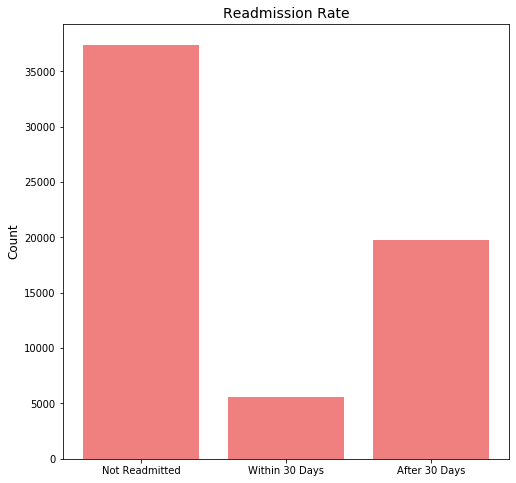

In [9]:
plt.figure(figsize=(8,8))
plt.bar(x, y, color ='lightcoral')
plt.title('Readmission Rate', fontsize=14)
plt.ylabel('Count', fontsize=12)
# plt.savefig('Readmit_rate.png')
plt.show()

Next, we looked at age. From the literature and the below graph, we see that age has a non-linear effect on readmission. Patients 0-30 years old are rarely readmitted. Patients 30-60 are more likely to be readmitted. Then as patients reach 60-100, this value decreases. 

In [10]:
age_prct = pd.DataFrame(df.groupby(by = 'age')['readmitted'].value_counts())

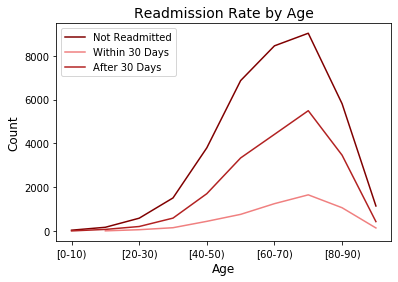

In [11]:
age_prct.unstack().plot(kind='line', color=['maroon', 'lightcoral', 'firebrick'], figsize=(6,4))
plt.xlabel('Age', fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.title('Readmission Rate by Age', fontsize=14)
plt.legend(['Not Readmitted', 'Within 30 Days', 'After 30 Days'])
# plt.savefig('Readmit_vs_age.png')

Finally, we looked at how the patient's race affects readmission. From the American Diabetes Assoc, Black and Hispanic populations have a greater incidence of diabetes than Asian and Caucasian populations. 

In [12]:
race_prct = pd.DataFrame(df.groupby(by = 'race')['readmitted'].value_counts(normalize = True))

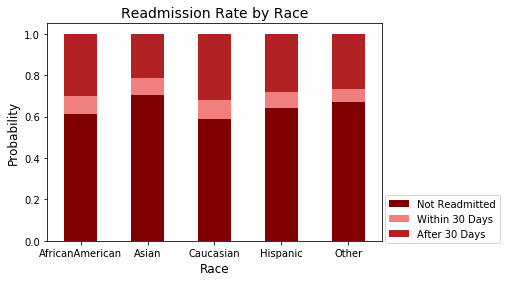

In [13]:
race_prct.unstack().plot(kind='bar', color=['maroon', 'lightcoral', 'firebrick'], stacked=True)
plt.xlabel('Race', fontsize=12)
plt.xticks(rotation=0)
plt.ylabel('Probability',fontsize=12)
plt.title('Readmission Rate by Race', fontsize=14)
plt.legend(['Not Readmitted', 'Within 30 Days', 'After 30 Days'],loc=(1.01,-.01))

## Dummy Classifier before Feature Engineering

In [14]:
X = df.drop('readmitted', axis = 1)
y = df.readmitted

### Dummy Classifier

In [15]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X, y)
dummy_clf.predict(X)
print("Dummy Model Accuracy: ", dummy_clf.score(X, y))

Dummy Model Accuracy:  0.46342862606367724


## Feature Engineering

Was the patient given a A1C test at all?

In [16]:
df['A1C_test'] = np.where(df.A1Cresult == 'None', 0, 1)

Let's visualize this distribution of HbA1c tests.

In [17]:
a1c_prct = df.A1C_test.value_counts(normalize=True) * 100

Text(0.5, 1.0, 'HbA1c Test Coverage')

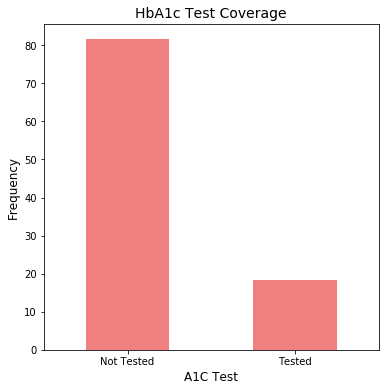

In [18]:
a1c_prct.plot(kind = 'bar', color = 'lightcoral', figsize=(6,6))
plt.xlabel('A1C Test', fontsize=12)
plt.xticks([0,1,],labels= ['Not Tested', 'Tested'])
plt.xticks(rotation=0)
plt.ylabel('Frequency',fontsize=12)
plt.title('HbA1c Test Coverage', fontsize=14)
#plt.savefig('Images/HbA1c_test.png')

Was the patient's meds changed during the hospitalization?

In [19]:
df.change = np.where(df.change == 'No', 0, 1)

Was the patient tested and meds changed?

In [20]:
df['A1C_test_and_changed'] = np.where((df.change == 1) & (df.A1C_test == 1), 1, 0)

From domain knowledge, patients are readmitted at different rates based on their age brackets.

In [21]:
conditions = [
    (df.age ==  '[0-10)') | (df.age == '[10-20)') | (df.age == '[20-30)'),
    (df.age == '[30-40)') | (df.age == '[40-50)') | (df.age == '[50-60)'),
    (df.age == '[60-70)') | (df.age == '[70-80)') | (df.age == '[80-90)') | (df.age == '[90-100')]

choices = [
    '[0-30)',
    '[30-60]',
    '[60-100)']

In [22]:
df['binned_age'] = np.select(conditions, choices, default=np.nan)

In [23]:
df = df[df.binned_age != 'nan']

In [24]:
df.drop(['age'], axis=1, inplace=True) # Dropping for correlation

Is diabetes one of the three primary diagnoses for the hospitalization?

In [25]:
df['diabetes_as_diag_1'] = np.where((df.diag_1 >= 250) & (df.diag_1 <251), 1, 0)
df['diabetes_as_diag_2'] = np.where((df.diag_2 >= 250) & (df.diag_2 <251), 1, 0)
df['diabetes_as_diag_3'] = np.where((df.diag_3 >= 250) & (df.diag_3 <251), 1, 0)

In [26]:
df.drop(['diag_1', 'diag_2', 'diag_3'], axis=1, inplace=True) # Dropping for correlation

To pare down some features, we removed drugs that had fewer than 5000 (1/12 of the total) patients using them. 

In [27]:
meds_to_remove = ['repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'tolbutamide', 
            'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 
            'citoglipton', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 
            'metformin-rosiglitazone', 'metformin-pioglitazone']
df.drop(meds_to_remove, axis=1, inplace=True)

In [28]:
df.shape

(61025, 28)

How many patients had diabetes as one of the top 3 diagnoses for inpatient visit?

In [29]:
print("Number of patients with diabetes as top3 diagnosis: ", 
      11495 + 8227 + 4559) # Yes, for diag3, diag2, diag1, respectively

Number of patients with diabetes as top3 diagnosis:  24281


In [30]:
print("Percent of inpatient visits with diabetes listed in top 3 diagnoses: ", 24281 / len(df) * 100)

Percent of inpatient visits with diabetes listed in top 3 diagnoses:  39.788611224907825


In [31]:
print("Percent of patients who received HbA1c test: ", len(df[df.A1C_test == 1]) / len(df) * 100)

Percent of patients who received HbA1c test:  18.55960671855797


In [32]:
print("Percent of patients who change meds after HbA1c tesT: ", 
      len(df[df.A1C_test_and_changed == 1]) / len(df[df.A1C_test == 1]))

Percent of patients who change meds after HbA1c tesT:  0.5580964153275649


## Modeling

We printed 4 major metrics to get a better idea of how our model was performing, but we focused on F1 score as our main metric. We wanted a more well-rounded model, and did not see how false positives or false negatives would be relatively worse in either case.

Because this is multiclass, average had to set to weighted.

In [33]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds, average='weighted')))
    print("Recall Score: {}".format(recall_score(labels, preds, average='weighted')))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds, average='weighted')))

## Logistic Regression: No Poly/Interaction Features

This was the best performing model and was used for further analysis/presentation. Iterative steps are included below these results and include many models of both logistic regression and decision trees.

Separate into features and target feature.

In [34]:
X = df.drop('readmitted', axis = 1)
y = df.readmitted

In [35]:
continuous_variables = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
                       'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
categorical_variables = [x for x in X.columns if x not in continuous_variables]

In [36]:
df_cont = X[continuous_variables]
df_cate = X[categorical_variables]

In [75]:
df_cate.binned_age.value_counts()

[60-100)    40635
[30-60]     19195
[0-30)       1195
Name: binned_age, dtype: int64

Get dummy variables for categorical variables.

In [37]:
dummy_df_cate = pd.get_dummies(df_cate)

In [38]:
dummy_df_cate.shape

(61025, 45)

Concatenating our cont and cate features back together.

In [39]:
df_all = pd.concat([df_cont, dummy_df_cate], axis = 1)

In [40]:
df_all.shape

(61025, 53)

### Test Train Split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(df_all, y, random_state=30)
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape)
print("Training set - Features: ", X_test.shape, "Target: ",y_test.shape)

Training set - Features:  (45768, 53) Target:  (45768,)
Training set - Features:  (15257, 53) Target:  (15257,)


### Running Model

In [42]:
logreg_nopoly = LogisticRegressionCV(random_state=30, max_iter=1000)
model_log_nopoly = logreg_nopoly.fit(X_train, y_train)

In [43]:
y_pred = model_log_nopoly.predict(X_test)

In [44]:
print_metrics(y_pred, y_test)

Precision Score: 0.8988571301977448
Recall Score: 0.6024120076030675
Accuracy Score: 0.6024120076030675
F1 Score: 0.7061286748857043


In [45]:
import pickle

In [46]:
pickle.dump(logreg_nopoly, open('diabetes_model.pkl', 'wb'))

In [45]:
results = pd.DataFrame(model_log_nopoly.coef_, columns=X_train.columns).T

This dataframe has the coefficients for the three classes (0,1,2). Selecting just to see the highest values.

In [46]:
results = results[(results > .08) | (results < -.08)]

## Logistic Regression: Poly/Interaction Features

Does including polynomial and interaction features improve the model?

In [47]:
X = df.drop('readmitted', axis = 1)
y = df.readmitted

### Generating Polynomical/Interaction Features

In [48]:
continuous_variables = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
                       'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
categorical_variables = [x for x in X.columns if x not in continuous_variables]

In [49]:
df_cont = X[continuous_variables]
df_cate = X[categorical_variables]

In [77]:
df_cate

,race,gender,admission_type_id,discharge_disposition_id,admission_source_id,max_glu_serum,A1Cresult,metformin,glipizide,glyburide,insulin,change,diabetesMed,A1C_test,A1C_test_and_changed,binned_age,diabetes_as_diag_1,diabetes_as_diag_2,diabetes_as_diag_3
1,Caucasian,Female,1,1,7,None,None,No,No,No,Up,1,Yes,0,0,[0-30),0,1,0
3,Caucasian,Male,1,1,7,None,None,No,No,No,Up,1,Yes,0,0,[30-60],0,1,0
4,Caucasian,Male,1,1,7,None,None,No,Steady,No,Steady,1,Yes,0,0,[30-60],0,0,1
5,Caucasian,Male,2,1,2,None,None,No,No,No,Steady,0,Yes,0,0,[30-60],0,0,1
7,Caucasian,Male,1,1,7,None,None,No,No,Steady,No,0,Yes,0,0,[60-100),0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,Caucasian,Female,1,1,7,None,>7,No,No,Up,Steady,1,Yes,1,1,[60-100),0,0,1
101755,Other,Female,1,1,7,None,>8,No,Steady,No,Up,1,Yes,1,1,[30-60],0,0,0
101756,Other,Female,1,1,7,None,None,No,No,No,Steady,0,Yes,0,0,[60-100),0,0,0
101758,Caucasian,Female,1,1,7,None,None,No,No,No,Up,1,Yes,0,0,[60-100),0,0,0


Generating polynomial and interaction features for continuous variables.

In [50]:
poly_cont = PolynomialFeatures(2)
poly_df_cont_data = poly_cont.fit_transform(df_cont)
poly_df_cont_cols = poly_cont.get_feature_names(df_cont.columns)
poly_df_cont = pd.DataFrame(poly_df_cont_data, columns=poly_df_cont_cols) # 45 features

In [51]:
poly_df_cont.shape

(61025, 45)

Generating interaction features for categorical variables.

In [52]:
dummy_df_cate = pd.get_dummies(df_cate)

In [53]:
poly_cate = PolynomialFeatures(interaction_only=True)
poly_df_cate_data = poly_cate.fit_transform(dummy_df_cate)
poly_df_cate_cols = poly_cate.get_feature_names(dummy_df_cate.columns)
poly_df_cate = pd.DataFrame(poly_df_cate_data, columns=poly_df_cate_cols) # 1,036 features

In [54]:
poly_df_cate.shape

(61025, 1036)

Concatenating our cont and cate features back together.

In [55]:
df_all = pd.concat([poly_df_cont, poly_df_cate], axis = 1) # 1,081 features total

In [56]:
df_all.shape

(61025, 1081)

### Train Test Split

In [57]:
X_train, X_test, y_train, y_test = train_test_split(df_all, y, random_state=30)
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape)
print("Training set - Features: ", X_test.shape, "Target: ",y_test.shape)

Training set - Features:  (45768, 1081) Target:  (45768,)
Training set - Features:  (15257, 1081) Target:  (15257,)


Scaling our data: fit to the training set then apply to both train and test sets.

In [58]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_train.columns)

### Removing Correlated Features

Want to remove correlated features.

In [59]:
corr_matrix = X_train.corr().abs()

In [60]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [61]:
correlated = [column for column in upper.columns if any(upper[column] > 0.75)]
print("Num of Removed Features: ", len(correlated))
X_train.drop(columns=correlated, inplace=True)
X_test.drop(columns=correlated, inplace=True)

Num of Removed Features:  428


### Running the Model

In [62]:
logreg = LogisticRegressionCV(random_state=30, max_iter=1000)
model_log = logreg.fit(X_train, y_train)

In [63]:
y_pred = model_log.predict(X_test)
y_pred_train = model_log.predict(X_train)

Test metrics:

In [64]:
print_metrics(y_pred, y_test)


Precision Score: 0.878476112823396
Recall Score: 0.6000524349478927
Accuracy Score: 0.6000524349478927
F1 Score: 0.6974500889102002


Training metrics to ensure not overfitting:

In [65]:
print_metrics(y_pred_train, y_train)

Precision Score: 0.8855551820076031
Recall Score: 0.6088751966439434
Accuracy Score: 0.6088751966439434
F1 Score: 0.7051051372857531


Just grabbing the top 10 positive and negative features because there are 1000 total features.

In [66]:
info = list(tuple(zip(X_train.columns, model_log.coef_[0])))
info.sort(key = lambda x: x[1]) 
top_10_pos = info[-10:]
top_10_neg = info[:10]

In [67]:
top_10_neg

[('number_inpatient', -0.1638442434818923),
 ('number_diagnoses', -0.10233336085419192),
 ('admission_source_id max_glu_serum_None', -0.08254081093691162),
 ('number_emergency', -0.07650544064795876),
 ('number_outpatient', -0.059371989527597056),
 ('time_in_hospital', -0.05603253101460419),
 ('discharge_disposition_id binned_age_[30-60]', -0.032153581466377666),
 ('num_procedures number_emergency', -0.030348182515057477),
 ('discharge_disposition_id diabetes_as_diag_1', -0.03021334118394899),
 ('discharge_disposition_id metformin_Steady', -0.02695735377818883)]

In [68]:
top_10_pos

[('admission_type_id max_glu_serum_None', 0.01828047882318645),
 ('diabetes_as_diag_3 metformin_Steady', 0.019380333101187537),
 ('admission_source_id change', 0.019397825725268644),
 ('diabetes_as_diag_3 metformin_Up', 0.020870950494928382),
 ('glyburide_Steady binned_age_[30-60]', 0.022283443671238974),
 ('A1C_test diabetes_as_diag_1', 0.027364724279092572),
 ('number_outpatient^2', 0.028064394774789496),
 ('discharge_disposition_id admission_source_id', 0.029890207791643874),
 ('num_procedures', 0.03529798221610847),
 ('number_emergency^2', 0.04668965402567975)]

## GridSearch CV

Tested Cs (0.01, 0.1, 1, 10, 20), cv (1, 3, 5, 7), penalty (L1, L2), and max_iter (100, 500, 1000), but best estimator performed worse than default by 2%.

In [69]:
# logreg_grid = LogisticRegressionCV(random_state=30, max_iter=1000, n_jobs=-1)

# param_grid ={'Cs': [1, 10, 20], 
#             'cv': [1, 3, 5, 7]}

# #create the instance of GridSearchCV using the F1 metric for our scoring. 
# scorer = make_scorer(f1_score, average='weighted')
# logreg_grid=GridSearchCV(logreg_grid, param_grid, scoring=scorer, verbose=2, n_jobs=-1)

In [70]:
# logreg_grid.fit(X_train,y_train)

In [71]:
# y_pred = logreg_grid.best_estimator_.predict(X_test)

In [72]:
# print("Best Parameter Combination Found During Grid Search:")
# logreg_grid.best_params_

In [73]:
# print_metrics(y_test, y_pred)

## Logistic Regression with SMOTE

There is some class imbalance in the set, but SMOTE decreased F1 score by 1%. 

In [74]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state = 2)
# X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)

In [75]:
# X_train_smote.shape

In [76]:
# logreg = LogisticRegressionCV(random_state=30, max_iter=1000)
# model_log_smote = logreg.fit(X_train_smote, y_train_smote)

In [77]:
# y_pred = model_log_smote.predict(X_test)

In [78]:
# print_metrics(y_pred, y_test)

## Recursive Feature Elimination

RFE ran with over 600 features, but did not improve F1 score.

In [79]:
# rfe_log = LogisticRegressionCV(random_state=30, max_iter=1000)

In [80]:
# Instantiate a recursive eliminator object
# selector = RFECV(verbose=1, estimator=rfe_log, step=10, scoring='neg_mean_squared_error')

# # Fit recursive feature eliminator 
# selector.fit(X_train, y_train)

In [81]:
# selected_rfe = X_train.columns[selector.support_]
# removed_rfe = X_train.columns[~selector.support_]


In [82]:
# len(list(removed_rfe)) # We eliminated 30 features from our model

In [83]:
# list(selected_rfe) # Here are the features we are keeping

## Decision Tree

#### Baseline Decision Tree

In [84]:
clf = DecisionTreeClassifier()
model_dt = clf.fit(X_train,y_train)

y_pred_dt_test = model_dt.predict(X_test)

print_metrics(y_test,y_pred_dt_test)

Precision Score: 0.49161513184402705
Recall Score: 0.48515435537785934
Accuracy Score: 0.48515435537785934
F1 Score: 0.4882869868868028


#### Decision Tree with Class Weight Balanced

In [85]:
clf_balanced = DecisionTreeClassifier(class_weight = 'balanced')
model_dt1 = clf_balanced.fit(X_train,y_train)

y_pred_dt1_test = model_dt1.predict(X_test)

print_metrics(y_test,y_pred_dt1_test)

Precision Score: 0.49547026946827905
Recall Score: 0.48816936488169366
Accuracy Score: 0.48816936488169366
F1 Score: 0.4917001424323169


#### Decision Tree with SMOTE

In [86]:
sm = SMOTE(sampling_strategy='minority', random_state=23)
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)
smote_dtc = DecisionTreeClassifier()
smote_dtc.fit(X_train_smote, y_train_smote)
smote_pred = smote_dtc.predict(X_test)
print_metrics(y_test, smote_pred)

Precision Score: 0.49760525476775597
Recall Score: 0.4900045880579406
Accuracy Score: 0.4900045880579406
F1 Score: 0.49367378878518714


#### Decision Tree with Tomek Links

Commented out because took a long time to process, improved F1 score by 1%, but not better than logistic regression model.

In [87]:
# tl = TomekLinks()
# X_res, y_res = tl.fit_resample(X_train, y_train)

# tomek_dtc = DecisionTreeClassifier()
# tomek_dtc.fit(X_res, y_res)
# tomek_pred = tomek_dtc.predict(X_test)
# print_metrics(y_test, tomek_pred)

In [88]:
# F1: 0.50

#### GridSearchCV Decision Tree

Commented out because took a long time to process and did not improve F1 score.

In [89]:
# param_grid = {
#     'max_depth': range(1,31,1),
#     'criterion': ['gini','entropy'],
#     'splitter' : ['best','random']}
# scoring = {'f1':'f1_weighted', 'Accuracy': 'accuracy'}

In [90]:
# dtc_grid = DecisionTreeClassifier(class_weight='balanced')
# grid_tree = GridSearchCV(dtc_grid, param_grid, cv=5, scoring=scoring, refit= 'f1', verbose=1)
# grid_tree.fit(X_train,y_train)

In [91]:
# print(grid_tree.best_score_) # 0.4829 F1 Score
# print(grid_tree.best_params_) # {'criterion': 'gini', 'max_depth': 28, 'splitter': 'random'}

## Insights

We see from our best logistic regression model that many factors associated with diabetes and its treatment impact the rate of readmission. Unsurprisingly, if diabetes was listed as a main cause for the visit, then a patient was more likely to be readmitted within and after 30 days. These coefficients are more difficult to comprehend than with linear regression. A one unit increase in the feature corresponds to a change in the log odds of the class. What we can directly compare is the direction and magnitude of the relative changes.

For not being readmitted, the most influential factors were if you were not on diabetic medication and if you were young (0-30 years old). If you had diabetic medication, had visited inpatient in the last year, or were between 60-100 years old, you were less likely to not be readmitted (sorry for the double-negative).

For being readmitted within 30 days, previous inpatient visits, being 60-100 years old, and having diabetes as a main diagnosis increased the log odds. Interestingly, if you did not have a blood sugar test you were less likely to be readmitted within 30 days. However, you were more likley to be readmitted after 30 days. Suggesting that patients should have their blood sugar tested every visit because complications are not caught within 30 days but still arise. 